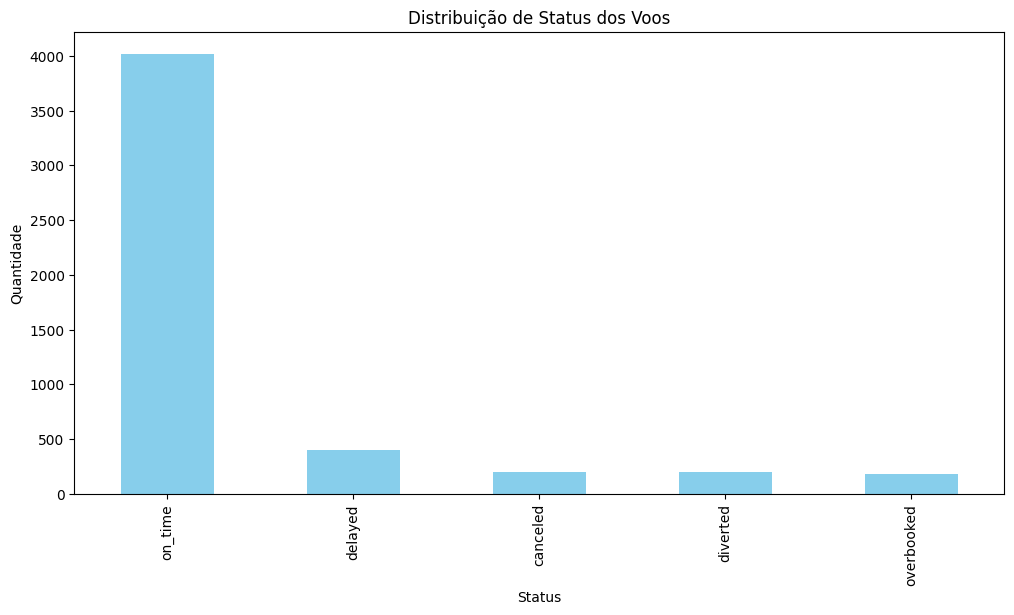

In [ ]:
import pandas as pd
import numpy as np
from faker import Faker
from datetime import datetime, timedelta
import random
import os
from pathlib import Path
import matplotlib.pyplot as plt

# Configurações
np.random.seed(42)
random.seed(42)
fake = Faker()

def generate_flight_data(num_records=5000):
    airlines = ['LATAM', 'GOL', 'Azul', 'Delta', 'American', 'United']
    airports = ['GRU', 'GIG', 'BSB', 'CNF', 'CGH', 'JFK', 'LAX', 'MIA']
    aircrafts = ['B737', 'A320', 'B787', 'A350', 'E190']
    problems = ['delay', 'canceled', 'diverted', 'maintenance', 'overbooked']
    
    data = []
    for _ in range(num_records):
        flight_id = f"{random.choice(['LA', 'G3', 'AD', 'DL', 'AA', 'UA'])}{random.randint(1000, 9999)}"
        airline = random.choice(airlines)
        origin = random.choice(airports)
        destination = random.choice([a for a in airports if a != origin])
        aircraft = random.choice(aircrafts)
        departure_time = fake.date_time_between(start_date='-30d', end_date='now')
        flight_duration = random.randint(30, 480)
        scheduled_arrival = departure_time + timedelta(minutes=flight_duration)
        
        # Introduzir problemas em 20% dos dados
        has_problem = random.random() < 0.2
        status = 'on_time'
        delay_minutes = 0
        cancellation_reason = None
        
        if has_problem:
            problem_type = random.choice(problems)
            if problem_type == 'delay':
                status = 'delayed'
                delay_minutes = random.randint(15, 360)
                actual_arrival = scheduled_arrival + timedelta(minutes=delay_minutes)
            elif problem_type == 'canceled':
                status = 'canceled'
                cancellation_reason = random.choice(['weather', 'mechanical', 'crew', 'air_traffic'])
                actual_arrival = None
            elif problem_type == 'diverted':
                status = 'diverted'
                actual_arrival = scheduled_arrival + timedelta(minutes=random.randint(30, 240))
            elif problem_type == 'maintenance':
                status = 'delayed'
                delay_minutes = random.randint(60, 480)
                actual_arrival = scheduled_arrival + timedelta(minutes=delay_minutes)
            elif problem_type == 'overbooked':
                status = 'overbooked'
                actual_arrival = scheduled_arrival
        else:
            actual_arrival = scheduled_arrival + timedelta(minutes=random.randint(-5, 15))
        
        # Adicionar outliers e dados inválidos (5% chance)
        if random.random() < 0.05:
            if random.random() < 0.5:
                flight_duration = -abs(flight_duration)  # Duração negativa
            else:
                origin = 'INVALID'
        
        data.append({
            'flight_id': flight_id,
            'airline': airline,
            'origin': origin,
            'destination': destination,
            'aircraft': aircraft,
            'departure_time': departure_time,
            'scheduled_arrival': scheduled_arrival,
            'actual_arrival': actual_arrival,
            'flight_duration': flight_duration,
            'status': status,
            'delay_minutes': delay_minutes,
            'cancellation_reason': cancellation_reason,
            'passengers': random.randint(50, 300) if status != 'canceled' else 0,
            'fuel_consumption': random.randint(5000, 30000) if status != 'canceled' else 0
        })
    
    return pd.DataFrame(data)

# Gerar e salvar dados
flight_data = generate_flight_data()

# Criar diretórios se não existirem
Path('data/raw').mkdir(parents=True, exist_ok=True)
Path('data/processed').mkdir(parents=True, exist_ok=True)

# Salvar dados
flight_data.to_csv('data/raw/flights.csv', index=False)

# Visualização inicial
plt.figure(figsize=(12, 6))
flight_data['status'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribuição de Status dos Voos')
plt.xlabel('Status')
plt.ylabel('Quantidade')
plt.savefig('data/reports/flight_status_distribution.png')
plt.show()

# Validação inicial após geração dos dados
from src.data_validation import FlightDataValidator

validator = FlightDataValidator('data/raw/flights.csv')
validation_results = validator.run_all_tests()

print(f"\nValidação concluída. Testes passados: {validation_results['passed_tests']}")
print(f"Erros encontrados: {len(validation_results['errors'])}")
for error in validation_results['errors']:
    print(f"- {error}")